# Recurrent Neural Network - LSTM


## Parte 1 - Preprocessamento de Dados

### Importar as bibliotecas

In [1]:
#%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math

from sklearn.metrics import mean_squared_error

#tf.__version__

### Importar a base de dados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

window     = 6
output_size = 3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/PROJETO_FINAL_BIMASTER/temperatura_BP-140106.csv')

#Conversão das temperaturas para número inteiro. Teste para ver se ajuda a RN. 
dataset = dataset.astype({"TEMPERATURA": int})

#Calculando tamanho dos conjuntos de treino e teste
train_size = math.ceil(len(dataset)*0.78)
test_size  = len(dataset) - train_size

#Separando conjuto de treino e teste apenas com valor da série
train_set = dataset.iloc[0:train_size, 1:2].values
test_set  = dataset.iloc[train_size:(train_size + test_size), 1:2].values

### gráfico da série temporal

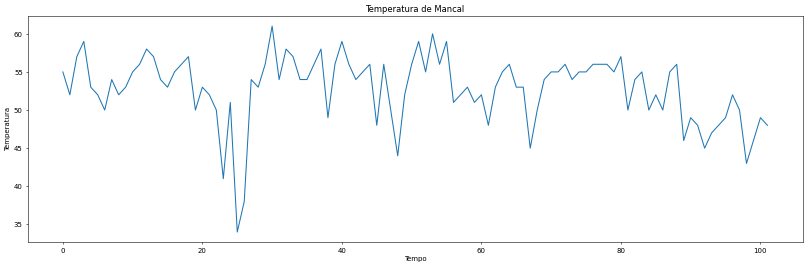

In [4]:
plt.figure(figsize=(20, 6), dpi=50)

plt.plot(dataset.iloc[0:len(dataset), 1:2].values)
plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.title("Temperatura de Mancal")
plt.show()

### Normalização

In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)

### Criar a estrutura de dados com janela WINDOW e output OUTPUTSIZE para entrada na RN

In [6]:
def prepareSetRN(windowSize, outputSize, flatSet ):
    preparedX = []
    preparedY = []
    setSize = len(flatSet)
    for i in range(windowSize, setSize - (outputSize-1)):
        preparedX.append(flatSet[i-window:i, 0])
        preparedY.append(flatSet[i:i + output_size, 0])

    preparedX, preparedY = np.array(preparedX), np.array(preparedY)
    return preparedX, preparedY

X_train = []
y_train = []
X_train, y_train = prepareSetRN(window, output_size, training_set_scaled)

### Reshaping

In [7]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

### Construção da Rede completa

In [10]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
#regressor.add(LSTM(units = 150, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(LSTM(units = 150, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.3))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = False))
regressor.add(Dropout(0.3))
 
# Adicionar a terceira camada LSTM e Dropout
#regressor.add(LSTM(units = 50, return_sequences = False))
#regressor.add(Dropout(0.3))

# Adicionar a terceira camada LSTM e Dropout
#regressor.add(LSTM(units = 50, return_sequences = False))
#regressor.add(Dropout(0.25))

# camada de saída
regressor.add(Dense(units = output_size, activation='linear'))
#Testar sigmoid e linear

# Compilar a rede
regressor.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Visualizar a rede
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 150)            91200     
_________________________________________________________________
dropout (Dropout)            (None, 6, 150)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 80)                73920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 243       
Total params: 165,363
Trainable params: 165,363
Non-trainable params: 0
_________________________________________________________________


### Treinamento

In [11]:
history = regressor.fit(X_train, y_train, epochs = 800, batch_size = 20)

Epoch 1/800
4/4 [==============================] - 3s 17ms/step - loss: 0.4614 - accuracy: 0.4167
Epoch 2/800
4/4 [==============================] - 0s 15ms/step - loss: 0.2599 - accuracy: 0.4306
Epoch 3/800
4/4 [==============================] - 0s 16ms/step - loss: 0.0704 - accuracy: 0.4028
Epoch 4/800
4/4 [==============================] - 0s 14ms/step - loss: 0.1169 - accuracy: 0.3333
Epoch 5/800
4/4 [==============================] - 0s 15ms/step - loss: 0.0628 - accuracy: 0.3056
Epoch 6/800
4/4 [==============================] - 0s 15ms/step - loss: 0.0630 - accuracy: 0.3472
Epoch 7/800
4/4 [==============================] - 0s 19ms/step - loss: 0.0596 - accuracy: 0.2083
Epoch 8/800
4/4 [==============================] - 0s 14ms/step - loss: 0.0508 - accuracy: 0.3333
Epoch 9/800
4/4 [==============================] - 0s 16ms/step - loss: 0.0486 - accuracy: 0.4444
Epoch 10/800
4/4 [==============================] - 0s 14ms/step - loss: 0.0508 - accuracy: 0.3750
Epoch 11/800
4/4 [=

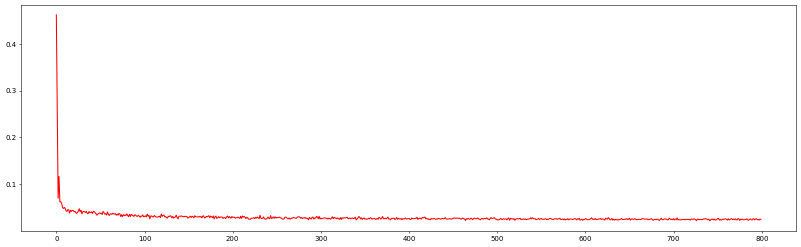

In [12]:
plt.figure(figsize=(20, 6), dpi=50)
plt.plot(history.history['loss'], color = 'red', label = 'Loss')

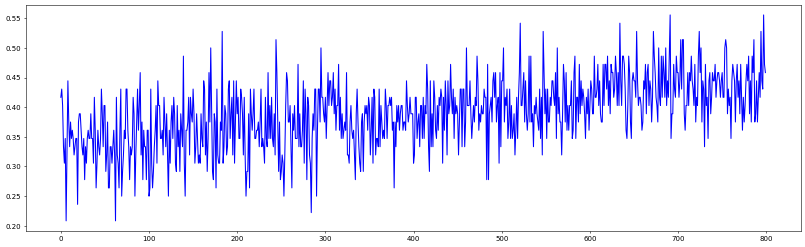

In [13]:
plt.figure(figsize=(20, 6), dpi=50)
plt.plot(history.history['accuracy'], color = 'blue', label = 'Accuracy')

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

### Construir a estrutura para teste

In [14]:
#Acréscimo da janela no conjunto de teste para pegar os últimos registros do treino
test_set_first_window  = dataset.iloc[train_size - window:(train_size + test_size), 1:2].values

test_set_scaled = sc.transform(test_set_first_window)

X_test = []
y_test = []

X_test, y_test = prepareSetRN(window, output_size, test_set_scaled)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [15]:
def backToFlat( windowSet ):
    flatSet     = []
    window_size = windowSet.shape[1]
    setSize     = len(windowSet)

    for i in range(0, setSize):
        flatSet.append(windowSet[i, 0])

    #Adiciona as demais colunas do último registro quando a janela > 1
    if window_size > 1:
        for i in range(1, window_size):
            flatSet.append(windowSet[setSize-1, i])

    flatSet = np.array(flatSet)

    return np.reshape(flatSet, (flatSet.shape[0], 1)) 

predicted = regressor.predict(X_train)
predicted = sc.inverse_transform(predicted)

training_predicted = backToFlat(predicted)

predicted = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted)

test_predicted = backToFlat(predicted)

### Visualizar os resultados de treino e teste

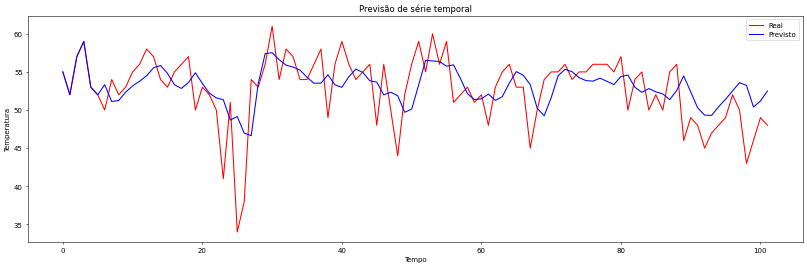

In [16]:
allTargetData = np.vstack((train_set, test_set))
allForecastedData = np.vstack((train_set[0:window], training_predicted, test_predicted))

plt.figure(figsize=(20, 6), dpi=50)
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [17]:
rmse = math.sqrt(mean_squared_error(test_set, test_predicted))
print('RMSE: ', rmse)

RMSE:  4.045042951104574


In [18]:
mse = mean_squared_error(test_set, test_predicted)
print('MSE: ',mse)

MSE:  16.362372476280804


In [19]:
mape = np.mean(np.abs((test_set - test_predicted) / test_set)) * 100
print('MAPE: ',mape, '%')

MAPE:  6.988350544802148 %
